In [2]:
!pip3 install wordcloud
!pip3 install transformers
!pip3 install datasets
!pip3 install torch



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached torch-2.9.0-cp313-cp313-win_amd64.whl.metadata (30 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached networkx-3.5-py3-none-any.whl.metadata (6.3 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
   ---------------------------------------- 0.0/109.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/109.3 MB ? eta -:--:--
   ---------------------------------------- 0.3/109.3 MB ? eta -:--:--
   ---------------------------------------- 0.3/109.3 MB ? eta -:--:--
   ---------------------------------------- 0.5/109.3 MB 781.0 kB/s eta 0:02:20
   ---------------------------------------- 0.8/109.3 MB 1.2 MB/s eta 0:01:32
   ---------------------------------------- 1.0/109.3 MB 1.2 MB/s eta 0:01:32
   ---------------------------------------- 1.3/109.3 MB 1.2 MB/s eta 0:01:31
    --------------------------------------- 1.6/109.3 MB 1.2 MB/s eta 0:01:32
    --------------------------------------- 1.8/109.3 MB 1.2 MB/s 


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from wordcloud import WordCloud

# For transformer-based model
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import torch

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [ ]:
# 2. DATA SOURCING
# Dataset citation:
# Liu, J., Johnson, K., & Faridani, S. (2019). Drug Review Dataset (DrugLib.com). 
# UCI Machine Learning Repository. https://archive.ics.uci.edu/dataset/461/drug+review+dataset+druglib+com


train_path = "../../Downloads/drug+review+dataset+druglib+com/drugLibTrain_raw.tsv"
test_path  = "../../Downloads/drug+review+dataset+druglib+com/drugLibTest_raw.tsv"

# Load training and test data
train_df = pd.read_csv(train_path, sep='\t')
test_df  = pd.read_csv(test_path, sep='\t')

# Combine for analysis
data = pd.concat([train_df, test_df], axis=0).reset_index(drop=True)
print("Data loaded successfully with shape:", data.shape)
data.head()


In [ ]:
## 2. RESEARCH QUESTIONS

Based on the Drug Review dataset, this project aims to answer the following questions:

1.  ** What is the overall distribution of sentiment (Positive, Neutral, Negative) in the drug reviews, and is the dataset balanced for training a classification model?**
    *   *Rationale: Understanding the class balance is crucial for model selection and interpretation of results. An imbalanced dataset might require techniques like oversampling or weighted loss functions.*

2.  **Is there a clear relationship between the users' numerical rating and the sentiment label we derived from it?**
    *   *Rationale: This validates our labeling strategy. We expect to see high ratings clustered in the "Positive" class and low ratings in the "Negative" class.*

3.  **What are the most frequent words (unigrams and bigrams) associated with Positive and Negative drug reviews?**
    *   *Rationale: This helps us understand the key factors driving user satisfaction and dissatisfaction, providing interpretability for the model's predictions and domain-specific insights.*

In [15]:
# 3. DATA PREPROCESSING (final, corrected version)

# keeping only the relevant columns
df = data[['urlDrugName', 'benefitsReview', 'rating']].dropna()

# Rename for simplicity
df = df.rename(columns={
    'urlDrugName': 'drug_name',
    'benefitsReview': 'review',
    'rating': 'rating'
})

# Convert rating (1–10) into sentiment labels
def label_sentiment(x):
    try:
        x = float(x)
    except:
        return 'neutral'
    if x >= 8:
        return 'positive'
    elif x <= 4:
        return 'negative'
    else:
        return 'neutral'

df['sentiment'] = df['rating'].apply(label_sentiment)

print("Sentiment distribution:\n", df['sentiment'].value_counts(), "\n")

# Clean review text
import re, nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop = set(stopwords.words('english'))

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = [w for w in text.split() if w not in stop]
    return " ".join(tokens)

df['clean_review'] = df['review'].apply(clean_text)

print("Sample cleaned data:\n")
print(df.head())


Sentiment distribution:
 sentiment
positive    2328
neutral      912
negative     880
Name: count, dtype: int64 

Sample cleaned data:

          drug_name                                             review  \
0         enalapril  slowed the progression of left ventricular dys...   
1  ortho-tri-cyclen  Although this type of birth control has more c...   
2           ponstel  I was used to having cramps so badly that they...   
3          prilosec  The acid reflux went away for a few months aft...   
4            lyrica  I think that the Lyrica was starting to help w...   

   rating sentiment                                       clean_review  
0       4  negative  slowed progression left ventricular dysfunctio...  
1       1  negative  although type birth control cons pros help cra...  
2      10  positive  used cramps badly would leave balled bed least...  
3       3  negative  acid reflux went away months days drug heartbu...  
4       2  negative  think lyrica starting help pain s

[nltk_data] Downloading package stopwords to /Users/apple/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/var/folders/ky/0zmfxgwn34g4_7py08z20p3r0000gn/T/ipykernel_50071/1207683047.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=df, palette='Set2')


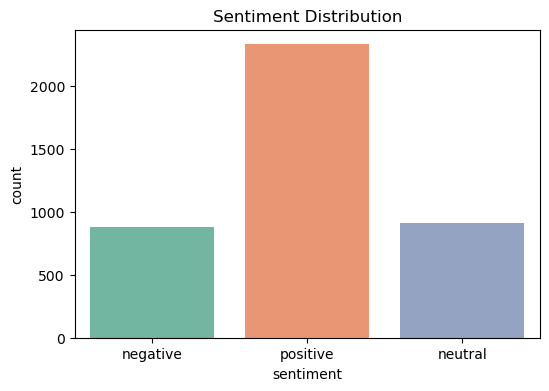

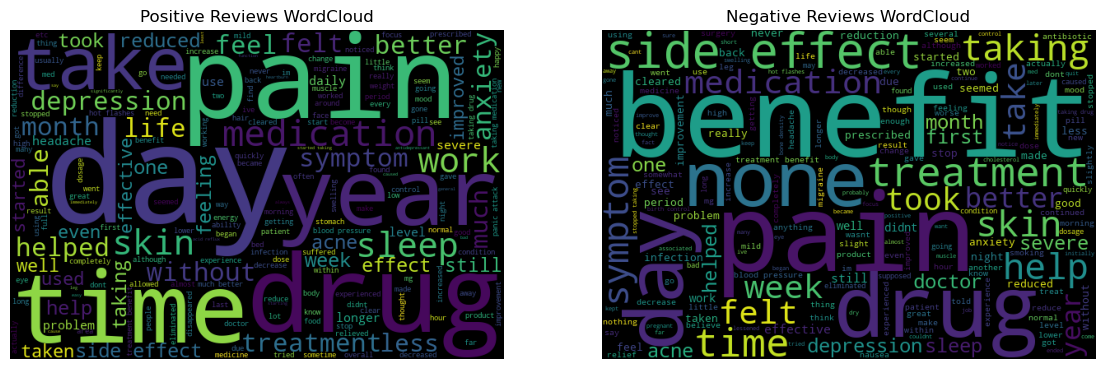

/var/folders/ky/0zmfxgwn34g4_7py08z20p3r0000gn/T/ipykernel_50071/1207683047.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_drugs.values, y=top_drugs.index, palette='cool')


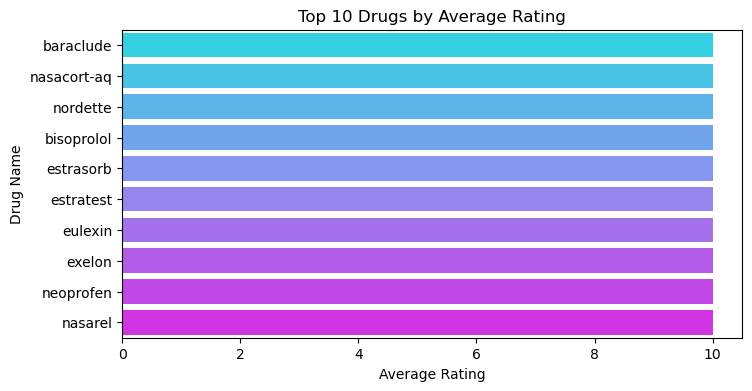

In [17]:
# 4. EDA

# Sentiment distribution
plt.figure(figsize=(6,4))
sns.countplot(x='sentiment', data=df, palette='Set2')
plt.title('Sentiment Distribution')
plt.show()

# Word clouds for positive and negative reviews
pos_text = " ".join(df[df['sentiment']=='positive']['clean_review'])
neg_text = " ".join(df[df['sentiment']=='negative']['clean_review'])

fig, ax = plt.subplots(1,2, figsize=(14,6))
ax[0].imshow(WordCloud(width=600, height=400).generate(pos_text))
ax[0].set_title("Positive Reviews WordCloud")
ax[0].axis('off')
ax[1].imshow(WordCloud(width=600, height=400).generate(neg_text))
ax[1].set_title("Negative Reviews WordCloud")
ax[1].axis('off')
plt.show()

# Top 10 drugs by average rating
top_drugs = (df.groupby('drug_name')['rating'].mean().sort_values(ascending=False).head(10))

plt.figure(figsize=(8, 4))
sns.barplot(x=top_drugs.values, y=top_drugs.index, palette='cool')
plt.title('Top 10 Drugs by Average Rating')
plt.xlabel('Average Rating')
plt.ylabel('Drug Name')
plt.show()




--- Logistic Regression Performance ---
              precision    recall  f1-score   support

    negative       0.76      0.33      0.46       192
     neutral       0.38      0.12      0.19       169
    positive       0.63      0.93      0.75       463

    accuracy                           0.62       824
   macro avg       0.59      0.46      0.47       824
weighted avg       0.61      0.62      0.57       824



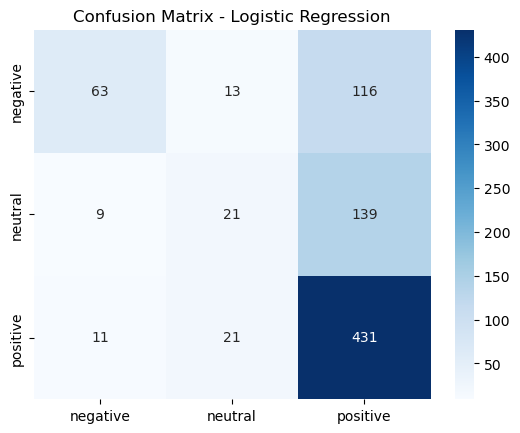

In [18]:
# 5. BASELINE MODEL: TF-IDF + LOGISTIC REGRESSION

# Split data
X_train, X_test, y_train, y_test = train_test_split(df['clean_review'], df['sentiment'], test_size=0.2, random_state=42)

# TF-IDF vectorization
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test)

# Train logistic regression
model_lr = LogisticRegression(max_iter=200)
model_lr.fit(X_train_vec, y_train)
pred_lr = model_lr.predict(X_test_vec)

# Performance
print("\n--- Logistic Regression Performance ---")
print(classification_report(y_test, pred_lr))

# Confusion matrix
cm = confusion_matrix(y_test, pred_lr)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d',
            xticklabels=model_lr.classes_,
            yticklabels=model_lr.classes_)
plt.title('Confusion Matrix - Logistic Regression')
plt.show()


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 234.3 kB/s eta 0:00:00 kB/s eta 0:00:01:01


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Found existing installation: datasets 4.2.0
Uninstalling datasets-4.2.0:
  Successfully uninstalled datasets-4.2.0


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Using cached datasets-4.2.0-py3-none-any.whl.metadata (18 kB)
Using cached datasets-4.2.0-py3-none-any.whl (506 kB)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


4.2.0


4.57.1
4.2.0


4.57.1
4.2.0


In [34]:
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
import torch

# Subsample (or full df)
sample_size = min(5000, len(df))
sample_df = df.sample(sample_size, random_state=42)

# Tokenize
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
encodings = tokenizer(list(sample_df['clean_review']), truncation=True, padding=True, max_length=128)

# Convert to torch Dataset
class ReviewDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

# Encode labels: positive=2, neutral=1, negative=0
label_map = {'negative':0, 'neutral':1, 'positive':2}
labels = [label_map[s] for s in sample_df['sentiment']]
dataset = ReviewDataset(encodings, labels)

# Split
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_ds, test_ds = torch.utils.data.random_split(dataset, [train_size, test_size])

# Model
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)

# Training arguments (evaluation_strategy removed)
training_args = TrainingArguments(
    output_dir='./results',
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    logging_dir='./logs',
    save_total_limit=1
)

# Metrics function
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits), dim=-1)
    return {
        'accuracy': accuracy_score(labels, predictions),
        'f1': f1_score(labels, predictions, average='macro'),
        'precision': precision_score(labels, predictions, average='macro'),
        'recall': recall_score(labels, predictions, average='macro')
    }

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics
)

# Train
trainer.train()


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ImportError: Using the `Trainer` with `PyTorch` requires `accelerate>=0.26.0`: Please run `pip install transformers[torch]` or `pip install 'accelerate>=0.26.0'`